# Scope Presentation

In [1]:
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from typing import Iterable, Any, List, Dict, TypeVar, cast

from moped import Model

T = TypeVar("T")

print(pkg_resources.get_distribution("moped").version)

1.6.5


## Cofactor effects

To display the benefits of including cofactor duplication, we calculated all single metabolite scopes (i.e. the scopes for the seed consisting only of a single metabolite and water) for the respective models. This has been done in three variations

- including no cofactors to the seed
- including the original cofactor compounds
- incuding on the mock cofactors resulting from cofactor duplication. 

The figure below displays the scope sizes (number of compounds contained in the scope) for each model and each variant to calculate the scopes.  
Apparently, without cofactors, the scopes are very small for most compounds (blue lines).  
This can be explained by the missing connectivity for reactions that require cofactors.  
The analysis including the actual cofactor compounds in the seed (orange lines) displays an unrealistically large metabolic scope for every compound, even for inorganic metabolites. 
This can be explained by the fact that cofactors are usually rather complex metabolites, and now all degradation processes are included during the network expansion.  
Therefore, the resulting metabolic scopes are no longer reflecting the property of the compound of interest, but rather the degradation products of the metabolized cofactor compounds.  
The corresponding analysis of models using cofactor duplication and mock cofactors duplicates in the seed (green lines) demonstrates that for small or inorganic metabolites, the scope is still relatively small.  
For more complex organic compounds, the metabolic scope is increasing without artificially increasing the scope size with degradation products of cofactors.  
This demonstrates the perks of including cofactor duplication and mock cofactors in seeds for biologically more realistic topological analyses.

In [5]:
def scope_comparison(file):
    m = Model()
    m.read_from_bigg(file)
    m.cofactor_duplication()
    m.reversibility_duplication()
    Scopes = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i])
        Scopes[i] = len(cpd)
    Scopes2 = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i] + list(m.cofactor_pairs.keys()))
        Scopes2[i] = len(cpd) - len(list(m.cofactor_pairs.keys()))

    Scopes3 = {}
    for i in m.compounds:
        _, cpd = m.scope(["h2o_c", i] + m.get_strong_cofactor_duplications())
        Scopes3[i] = len([i for i in cpd if not cast(str, i).endswith("__cof__")])
    return pd.DataFrame(
        {
            "without cof.": Scopes,
            "actual cof.": Scopes2,
            "cof. duplicates": Scopes3,
        }
    )


def plot_scope(df, ax, name):
    df["without cof."].sort_values().plot(ax=ax, linewidth=3)
    df["actual cof."].sort_values().plot(ax=ax, linewidth=3)
    df["cof. duplicates"].sort_values().plot(ax=ax, linewidth=3)
    ax.set(xticks=[])
    ax.grid()
    ax.set_xlabel("Metabolites")
    ax.set_ylabel("Number of producible Metabolites")
    ax.legend()
    ax.set_title(name, fontsize=15)
    return ax


Metabolic scopes in established models of E. coli(iML1515), B. subtilis(iYO844) and Synechocystis sp. PCC 6803 (iSynCJ816).  
The differently colored graphs represent the same analysis but including no cofactors, actual cofactors and cofactor duplicates in the seed.

In [6]:
df1 = scope_comparison("../data/models/iML1515.xml")
df2 = scope_comparison("../data/models/iSynCJ816.xml")
df3 = scope_comparison("../data/models/iYO844.xml")

No objective coefficients in model. Unclear what should be optimized


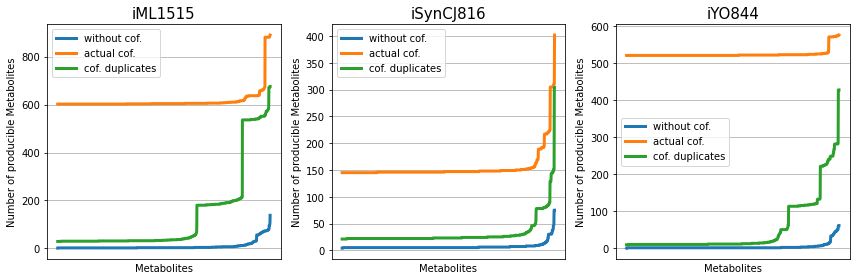

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_scope(df1, ax1, "iML1515")
plot_scope(df2, ax2, "iSynCJ816")
plot_scope(df3, ax3, "iYO844")
plt.tight_layout()
plt.show()

## E.coli core

In [2]:
def snd(x: Any, y: T) -> T:
    return y


def flatten(x: Iterable[Iterable[Any]]) -> List[Any]:
    return [j for i in x for j in i]


def group_mask(groups: Dict[str, List[str]]) -> List[int]:
    return flatten(
        [it.repeat(num, len(group)) for num, group in enumerate(groups.values())]
    )

In [3]:
m = Model()
m.read_from_bigg("../data/models/e_coli_core.xml")

m.cofactor_duplication()
m.reversibility_duplication()

scope_compounds = [
    i for i in m.compounds if "C" in m.compounds[i].formula and i[-2:] != "_e"
]
scopes = {
    i: len(snd(*m.scope([i, "h2o_c"] + m.get_weak_cofactor_duplications())))
    for i in scope_compounds
}

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


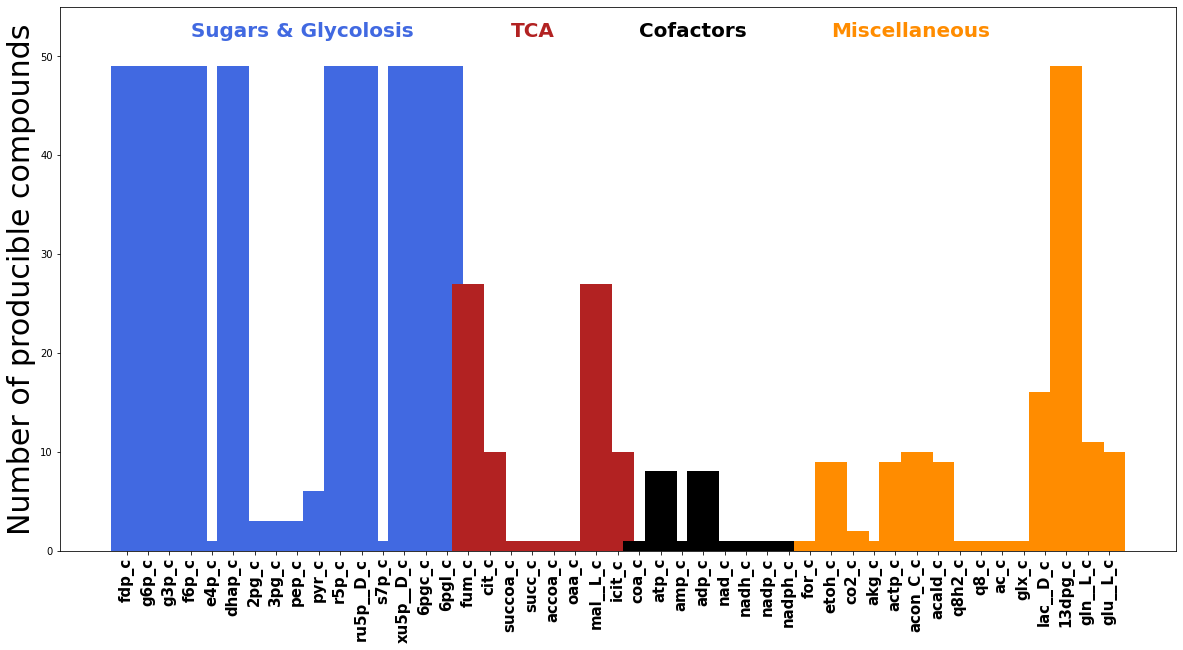

In [4]:
groups = {
    "Glycolosis": [
        "fdp_c",
        "g6p_c",
        "g3p_c",
        "f6p_c",
        "e4p_c",
        "dhap_c",
        "2pg_c",
        "3pg_c",
        "pep_c",
        "pyr_c",
        "r5p_c",
        "ru5p__D_c",
        "s7p_c",
        "xu5p__D_c",
        "6pgc_c",
        "6pgl_c",
    ],
    "TCA": [
        "fum_c",
        "cit_c",
        "succoa_c",
        "succ_c",
        "accoa_c",
        "oaa_c",
        "mal__L_c",
        "icit_c",
    ],
    "Cofactors": [
        "coa_c",
        "atp_c",
        "amp_c",
        "adp_c",
        "nad_c",
        "nadh_c",
        "nadp_c",
        "nadph_c",
    ],
    "Others": [
        "for_c",
        "etoh_c",
        "co2_c",
        "akg_c",
        "actp_c",
        "acon_C_c",
        "acald_c",
        "q8h2_c",
        "q8_c",
        "ac_c",
        "glx_c",
        "lac__D_c",
        "13dpg_c",
        "gln__L_c",
        "glu__L_c",
    ],
}


order = []
for i in list(groups):
    for j in groups[i]:
        order.append(j)

colors = ["royalblue", "firebrick", "black", "darkorange"]
group_colors = [colors[i] for i in group_mask(groups)]


x = flatten(groups.values())
y = [scopes[i] for i in x]


fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x, y, width=1.5, color=group_colors)
ax.set_ylim(0, 55)
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x, rotation=90, fontsize=15, fontweight="bold")
ax.text(3, 52, "Sugars & Glycolosis", weight="bold", color="royalblue", fontsize=20)
ax.text(18, 52, "TCA", weight="bold", color="firebrick", fontsize=20)
ax.text(24, 52, "Cofactors", weight="bold", color="black", fontsize=20)
ax.text(33, 52, "Miscellaneous", weight="bold", color="darkorange", fontsize=20)
ax.set_ylabel("Number of producible compounds", fontsize=30)
plt.show()